# Excitation - Structure - Response
Arthor: Shuaiwen Cui
Date: 2025-03-01

In [1]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in divide")

In [2]:
# DEPENDENCIES
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

# excitation generation
import ambient_vibration
import earthquake
import impact
import strongwind

# structure modelling
import model_build

# response calculation
import newmark_beta

In [3]:
# DATA GENERATION CONFIGURATION

## STRUCTURE - RELATED
nDOF = 5 # number of degrees of freedom

## GRAVITY
# g = 9.81 # acceleration due to gravity
g = 1 # use g as the unit

## EXCITATION - RELATED
signal_length = 6000 # number of points in the signal
dt = 0.01 # time step

## EXCITATION - RELATED - AMBIENT VIBRATION
signal_intensity_av_lb = 0.003*g # intensity of the signal, standard deviation of the white noise, lower bound
signal_intensity_av_ub = 0.004*g # intensity of the signal, standard deviation of the white noise, upper bound

# signals will be scaled later on, so the absolute value does not matter

## EXCITATION - RELATED - EARTHQUAKE
eq_strength = 0.6 # strength of the earthquake
eq_duration = 20.0 # duration of the earthquake
omegag = 15 # central frequency
zetag = 0.6 # damping ratio of the ground
fac_time = 12.21 # factor for time modulation
pos_time1 = 0.1 # positive time 1, to control the time modulation curve shape
pos_time2 = 0.5 # positive time 2, to control the time modulation curve shape

## EXCITATION - RELATED - IMPACT
# signal_intensity_ip = 0.5 * g # intensity of the signal, the amplitude of the signal. (absolute value)
# signal_std = 1 * g # standard deviation of the impact amplitude

signal_intensity_ip = 1 * g # intensity of the signal, the amplitude of the signal. (absolute value)
signal_std = 1 * g # standard deviation of the impact amplitude

# signals will be scaled later on, so the absolute value does not matter

## EXCITATION - RELATED - STRONG WIND
### signal_length, dt, nDOF are stated above. To modify parameters, one needs to modify the strongwind.py file.

## MODEL - RELATED : the absolute value does not matter, the final results will be scaled accordingly

# # ambient vibration
# me_av = 9e6
# ke_av = 1e11
# zeta_av = 0.001

# # earthquake
# me_eq = 9e6
# ke_eq = 1e11
# zeta_eq = 0.001

# # impact
# me_ip = 1e4
# ke_ip = 5e9
# zeta_ip = 0.0005

# # strong wind
# me_sw = 9e6
# ke_sw = 1e11
# zeta_sw = 0.001




# ambient vibration
me_av = 9e7
ke_av = 1e11
zeta_av = 0.001

# earthquake
me_eq = 9e7
ke_eq = 1e11
zeta_eq = 0.001

# impact
me_ip = 1e5
ke_ip = 5e9
zeta_ip = 0.0005

# strong wind
me_sw = 9e7
ke_sw = 1e11
zeta_sw = 0.001



In [4]:
## DATA MATRICES

num_samples = 1 # number of samples for each type of excitation

## EXCITATION
EXCITATION_AV = np.zeros((num_samples, nDOF, signal_length))
EXCITATION_EQ = np.zeros((num_samples, nDOF, signal_length))
EXCITATION_IP = np.zeros((num_samples, nDOF, signal_length))
EXCITATION_SW = np.zeros((num_samples, nDOF, signal_length))

### print the size of the matrices
print('EXCITATION_AV shape: ', EXCITATION_AV.shape)
print('EXCITATION_EQ shape: ', EXCITATION_EQ.shape)
print('EXCITATION_IP shape: ', EXCITATION_IP.shape)
print('EXCITATION_SW shape: ', EXCITATION_SW.shape)

## STRUCTURE

### Mass matrix, stiffness matrix, damping matrix
M_av, K_av, C_av = model_build.model_build(nDOF, me_av, ke_av, zeta_av)
M_eq, K_eq, C_eq = model_build.model_build(nDOF, me_eq, ke_eq, zeta_eq)
M_ip, K_ip, C_ip = model_build.model_build(nDOF, me_ip, ke_ip, zeta_ip)
M_sw, K_sw, C_sw = model_build.model_build(nDOF, me_sw, ke_sw, zeta_sw)

print('Mass matrix       M shape: ', M_av.shape)
print('Stiffness matrix  K shape: ', K_av.shape)
print('Damping matrix    C shape: ', C_av.shape)

## RESPONSE
RESPONSE_AV = np.zeros((num_samples, nDOF, signal_length))
RESPONSE_EQ = np.zeros((num_samples, nDOF, signal_length))
RESPONSE_IP = np.zeros((num_samples, nDOF, signal_length))
RESPONSE_SW = np.zeros((num_samples, nDOF, signal_length))

### print the size of the matrices
print('RESPONSE_AV shape: ', RESPONSE_AV.shape)
print('RESPONSE_EQ shape: ', RESPONSE_EQ.shape)
print('RESPONSE_IP shape: ', RESPONSE_IP.shape)
print('RESPONSE_SW shape: ', RESPONSE_SW.shape)

EXCITATION_AV shape:  (1, 5, 6000)
EXCITATION_EQ shape:  (1, 5, 6000)
EXCITATION_IP shape:  (1, 5, 6000)
EXCITATION_SW shape:  (1, 5, 6000)
Mass matrix       M shape:  (5, 5)
Stiffness matrix  K shape:  (5, 5)
Damping matrix    C shape:  (5, 5)
RESPONSE_AV shape:  (1, 5, 6000)
RESPONSE_EQ shape:  (1, 5, 6000)
RESPONSE_IP shape:  (1, 5, 6000)
RESPONSE_SW shape:  (1, 5, 6000)


In [5]:
# EXCITATION GENERATION

scale = 1
## AMBIENT VIBRATION
for i in range(num_samples):
    # print progress
    if i%50 == 0:
        print('AV %d / %d' % (i, num_samples))
    for j in range(nDOF):
        # generate the ambient vibration signal intensity randomly, between the lower bound and upper bound
        signal_intensity_av = 1 # scaling in the end
        EXCITATION_AV[i, j, :] = ambient_vibration.ambient_vibration_gen(signal_length, signal_intensity_av)

print('EXCITATION_AV generated.')

## EARTHQUAKE
for i in range(num_samples):
    # print progress
    if i%50 == 0:
        print('EQ %d / %d' % (i, num_samples))
    eq_temp = earthquake.earthquake_gen(signal_length, dt, eq_strength, eq_duration, omegag, zetag, fac_time, pos_time1, pos_time2)
    for j in range(nDOF):
        EXCITATION_EQ[i, j, :] = eq_temp

print('EXCITATION_EQ generated.')

## IMPACT
for i in range(num_samples):
    # print progress
    if i%50 == 0:
        print('IP %d / %d' % (i, num_samples))
    
    # pick a random DOF to apply the impact
    impact_dof = np.random.randint(0, nDOF)
    
    # generate the impact signal
    ip_temp = impact.impact_gen(signal_length, signal_intensity_ip, signal_std)
    
    # apply the impact signal to the selected DOF
    EXCITATION_IP[i, impact_dof, :] = ip_temp

print('EXCITATION_IP generated.')

## STRONG WIND
for i in range(num_samples):
    # print progress
    if i%50 == 0:
        print('SW %d / %d' % (i, num_samples))
    wd_temp = strongwind.strong_wind_gen(signal_length, nDOF, dt)
    for j in range(nDOF):
        EXCITATION_SW[i, j, :] = wd_temp[j, :]

print('EXCITATION_SW generated.')

AV 0 / 1
EXCITATION_AV generated.
EQ 0 / 1
EXCITATION_EQ generated.
IP 0 / 1
EXCITATION_IP generated.
SW 0 / 1
EXCITATION_SW generated.


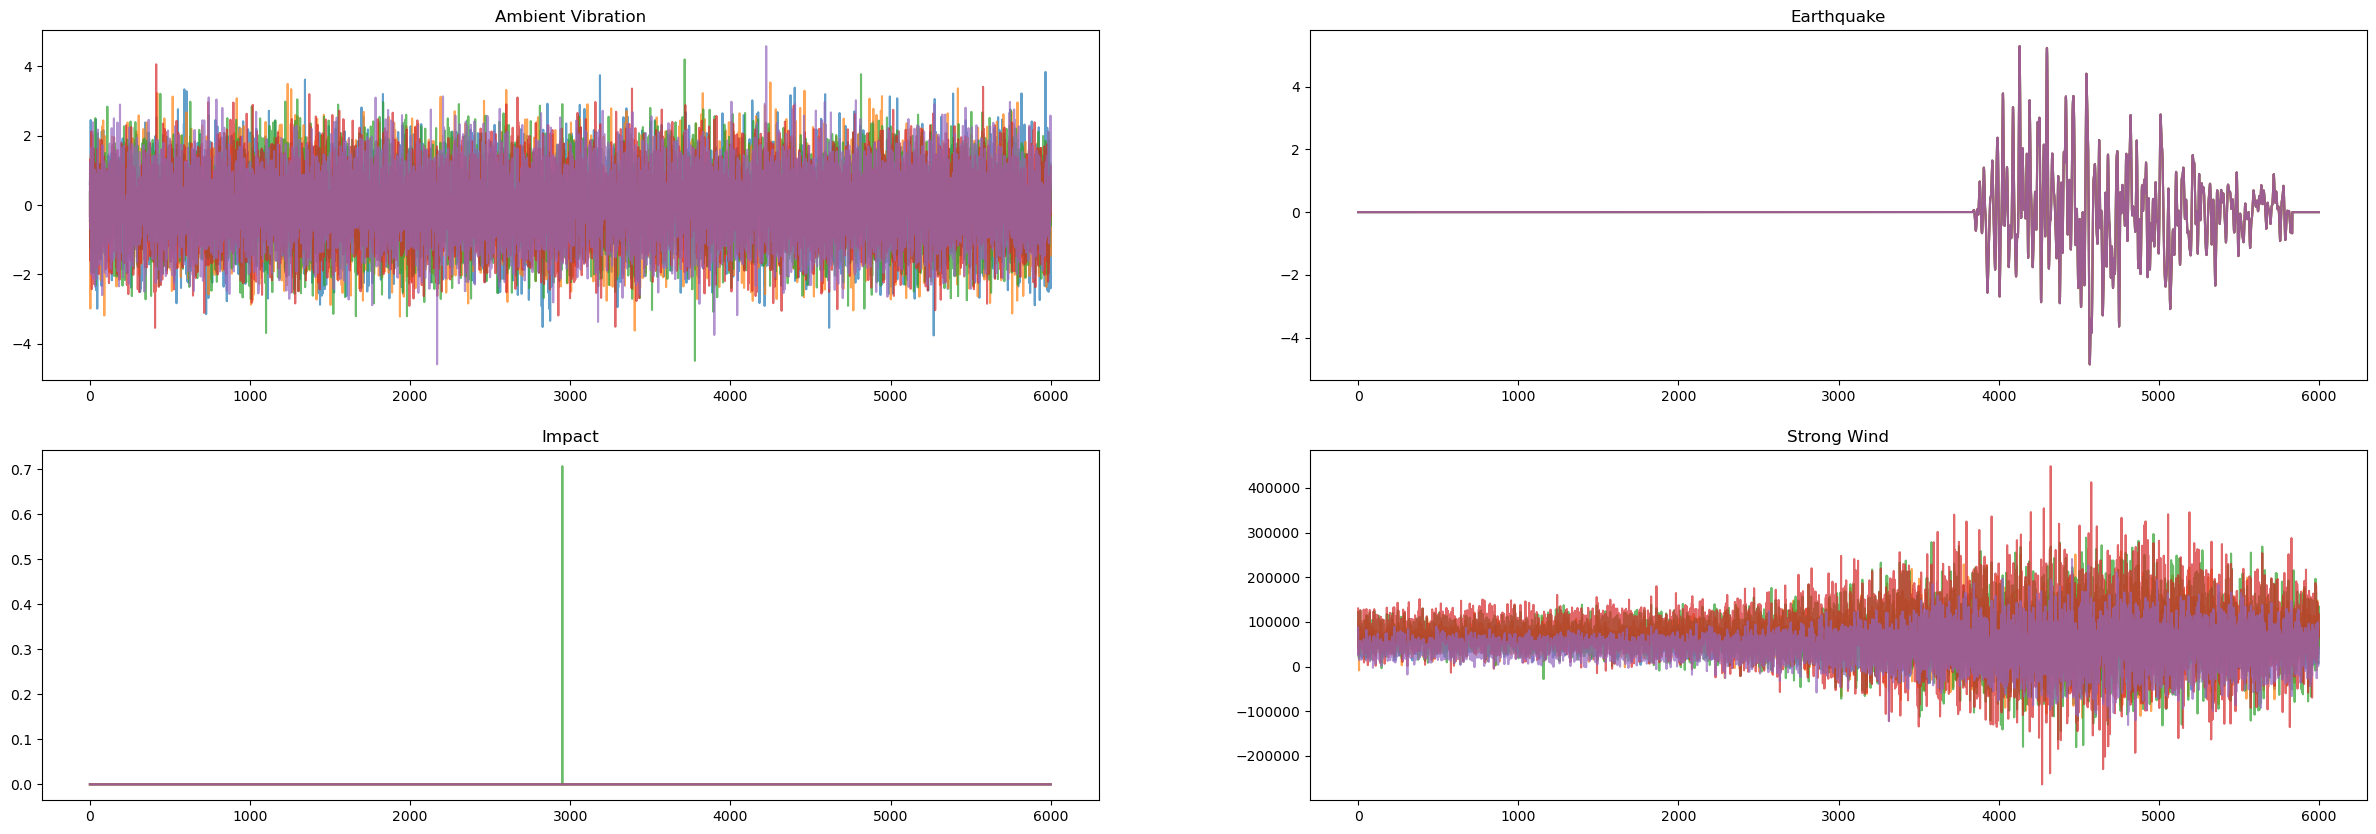

In [6]:
# VISUALIZATION of the EXCITATION

## determine an index to check
index_1 = 0
index_2 = 0

## subplot to show the excitation signals, each subplot contains all the DOFs
plt.figure(figsize=(30, 10))

## AMBIENT VIBRATION
plt.subplot(2, 2, 1)
plt.plot(EXCITATION_AV[index_1, :, :].T, alpha=0.7)
plt.title('Ambient Vibration')

## EARTHQUAKE
plt.subplot(2, 2, 2)
plt.plot(EXCITATION_EQ[index_1, :, :].T, alpha=0.7)
plt.title('Earthquake')

## IMPACT
plt.subplot(2, 2, 3)
plt.plot(EXCITATION_IP[index_1, :, :].T, alpha=0.7)
plt.title('Impact')

## STRONG WIND
plt.subplot(2, 2, 4)
plt.plot(EXCITATION_SW[index_1, :, :].T, alpha=0.7)
plt.title('Strong Wind')

plt.show()

In [7]:
# RESPONSE CALCULATION

## AMBIENT VIBRATION
for i in range(num_samples):
    # print progress
    if i%50 == 0:
        print('AV %d / %d' % (i, num_samples))
    
    RESPONSE_AV[i, :, :] = np.array(newmark_beta.newmark_beta(signal_length, nDOF, M_av, K_av, C_av, EXCITATION_AV[i, :, :] , dt))

print('RESPONSE_AV generated.')

## EARTHQUAKE
for i in range(num_samples):
    # print progress
    if i%50 == 0:
        print('EQ %d / %d' % (i, num_samples))
        
    RESPONSE_EQ[i, :, :]= np.array(newmark_beta.newmark_beta(signal_length, nDOF, M_eq, K_eq, C_eq, EXCITATION_EQ[i, :, :], dt))
    
print('RESPONSE_EQ generated.')

## IMPACT
for i in range(num_samples):
    # print progress
    if i%50 == 0:
        print('IP %d / %d' % (i, num_samples))
    
    RESPONSE_IP[i, :, :] = np.array(newmark_beta.newmark_beta(signal_length, nDOF, M_ip, K_ip, C_ip, EXCITATION_IP[i, :, :], dt))

print('RESPONSE_IP generated.')

## STRONG WIND
for i in range(num_samples):
    # print progress
    if i%50 == 0:
        print('SW %d / %d' % (i, num_samples))
    
    RESPONSE_SW[i, :, :] = np.array(newmark_beta.newmark_beta(signal_length, nDOF, M_sw, K_sw, C_sw, EXCITATION_SW[i, :, :], dt))

print('RESPONSE_SW generated.')

AV 0 / 1
RESPONSE_AV generated.
EQ 0 / 1
RESPONSE_EQ generated.
IP 0 / 1
RESPONSE_IP generated.
SW 0 / 1
RESPONSE_SW generated.


In [8]:
# RESPONSE NORMALIZATION

## AMBIENT VIBRATION
for i in range(num_samples):
    if i%50 == 0:
        print('AV %d / %d' % (i, num_samples))
    for j in range(nDOF):
        av_std = np.std(RESPONSE_AV[i, j, :])
        # make std = 1
        RESPONSE_AV[i, j, :] = RESPONSE_AV[i, j, :] / av_std

## EARTHQUAKE
for i in range(num_samples):
    if i%50 == 0:
        print('EQ %d / %d' % (i, num_samples))
    for j in range(nDOF):
        eq_max_abs = np.max(np.abs(RESPONSE_EQ[i, j, :]))
        # make max abs = 1
        RESPONSE_EQ[i, j, :] = RESPONSE_EQ[i, j, :] / eq_max_abs

## IMPACT
for i in range(num_samples):
    if i%50 == 0:
        print('IP %d / %d' % (i, num_samples))
    for j in range(nDOF):
        ip_max_abs = np.max(np.abs(RESPONSE_IP[i, j, :]))
        # make max abs = 1
        RESPONSE_IP[i, j, :] = RESPONSE_IP[i, j, :] / ip_max_abs

## STRONG WIND
for i in range(num_samples):
    if i%50 == 0:
        print('SW %d / %d' % (i, num_samples))
    for j in range(nDOF):
        sw_max_abs = np.max(np.abs(RESPONSE_SW[i, j, :]))
        # make max abs = 1
        RESPONSE_SW[i, j, :] = RESPONSE_SW[i, j, :] / sw_max_abs

AV 0 / 1
EQ 0 / 1
IP 0 / 1
SW 0 / 1


In [9]:
# RESPONSE SCALING

## AMBIENT VIBRATION

### scaling according to the pioneer sensing, the standard deviation of the real is std_av = 0.0032428331468619836 (unit = g) , for synthesizing, lets make the scaling factor a random number ranging from 0.9 to 1.1 times the std_av
scaling_factor_av = np.random.uniform(0.9, 1.1, num_samples) * 0.0032428331468619836

for i in range(num_samples):
    if i%50 == 0:
        print('AV %d / %d' % (i, num_samples))
    for j in range(nDOF):
        RESPONSE_AV[i, j, :] = RESPONSE_AV[i, j, :] * scaling_factor_av[i]
        
## EARTHQUAKE

### lets make the scaling factor a random number ranging from 0.1 to 3.0, then apply this scaling factor to the response
scaling_factor_eq = np.random.uniform(0.1, 3.0, num_samples)

for i in range(num_samples):
    if i%50 == 0:
        print('EQ %d / %d' % (i, num_samples))
    for j in range(nDOF):
        RESPONSE_EQ[i, j, :] = RESPONSE_EQ[i, j, :] * scaling_factor_eq[i]

## IMPACT

### similar to the earthquake, lets make the scaling factor a random number ranging from 0.1 to 3.0, then apply this scaling factor to the response

scaling_factor_ip = np.random.uniform(0.1, 3.0, num_samples)

for i in range(num_samples):
    if i%50 == 0:
        print('IP %d / %d' % (i, num_samples))
    for j in range(nDOF):
        RESPONSE_IP[i, j, :] = RESPONSE_IP[i, j, :] * scaling_factor_ip[i]

## STRONG WIND

### The max value of strong wind is around 1.5 - 2.5 times the max value of the corresponding ambient vibration, lets calculate the max values of the corresponding ambient vibration first, then times a random number ranging from 1.5 to 2.5 to get the max value of the strong wind, then calculate the scaling factor, then apply the scaling factor to the response

scaling_factor_sw = np.zeros(num_samples)

for i in range(num_samples):
    if i%50 == 0:
        print('SW %d / %d' % (i, num_samples))
    for j in range(nDOF):
        scaling_factor_sw[i] = np.random.uniform(1.5, 2.5)
        max_av = np.max(np.abs(RESPONSE_AV[i, j, :]))
        max_sw = max_av * scaling_factor_sw[i]
        RESPONSE_SW[i, j, :] = RESPONSE_SW[i, j, :] * max_sw



AV 0 / 1
EQ 0 / 1
IP 0 / 1
SW 0 / 1


In [10]:
# # RESPONSE SUPERPOSITION

# ## RESPONSE_EQ = RESPONSE_AV + RESPONSE_EQ

# for i in range(num_samples):
#     if i%50 == 0:
#         print('EQ %d / %d' % (i, num_samples))
#     for j in range(nDOF):
#         RESPONSE_EQ[i, j, :] = RESPONSE_AV[i, j, :] + RESPONSE_EQ[i, j, :]

# ## RESPONSE_IP = RESPONSE_AV + RESPONSE_IP

# for i in range(num_samples):
#     if i%50 == 0:
#         print('IP %d / %d' % (i, num_samples))
#     for j in range(nDOF):
#         RESPONSE_IP[i, j, :] = RESPONSE_AV[i, j, :] + RESPONSE_IP[i, j, :]

# # RESPONSE_SW = RESPONSE_AV + RESPONSE_SW

# for i in range(num_samples):
#     if i%50 == 0:
#         print('SW %d / %d' % (i, num_samples))
#     for j in range(nDOF):
#         RESPONSE_SW[i, j, :] = RESPONSE_AV[i, j, :] + RESPONSE_SW[i, j, :]


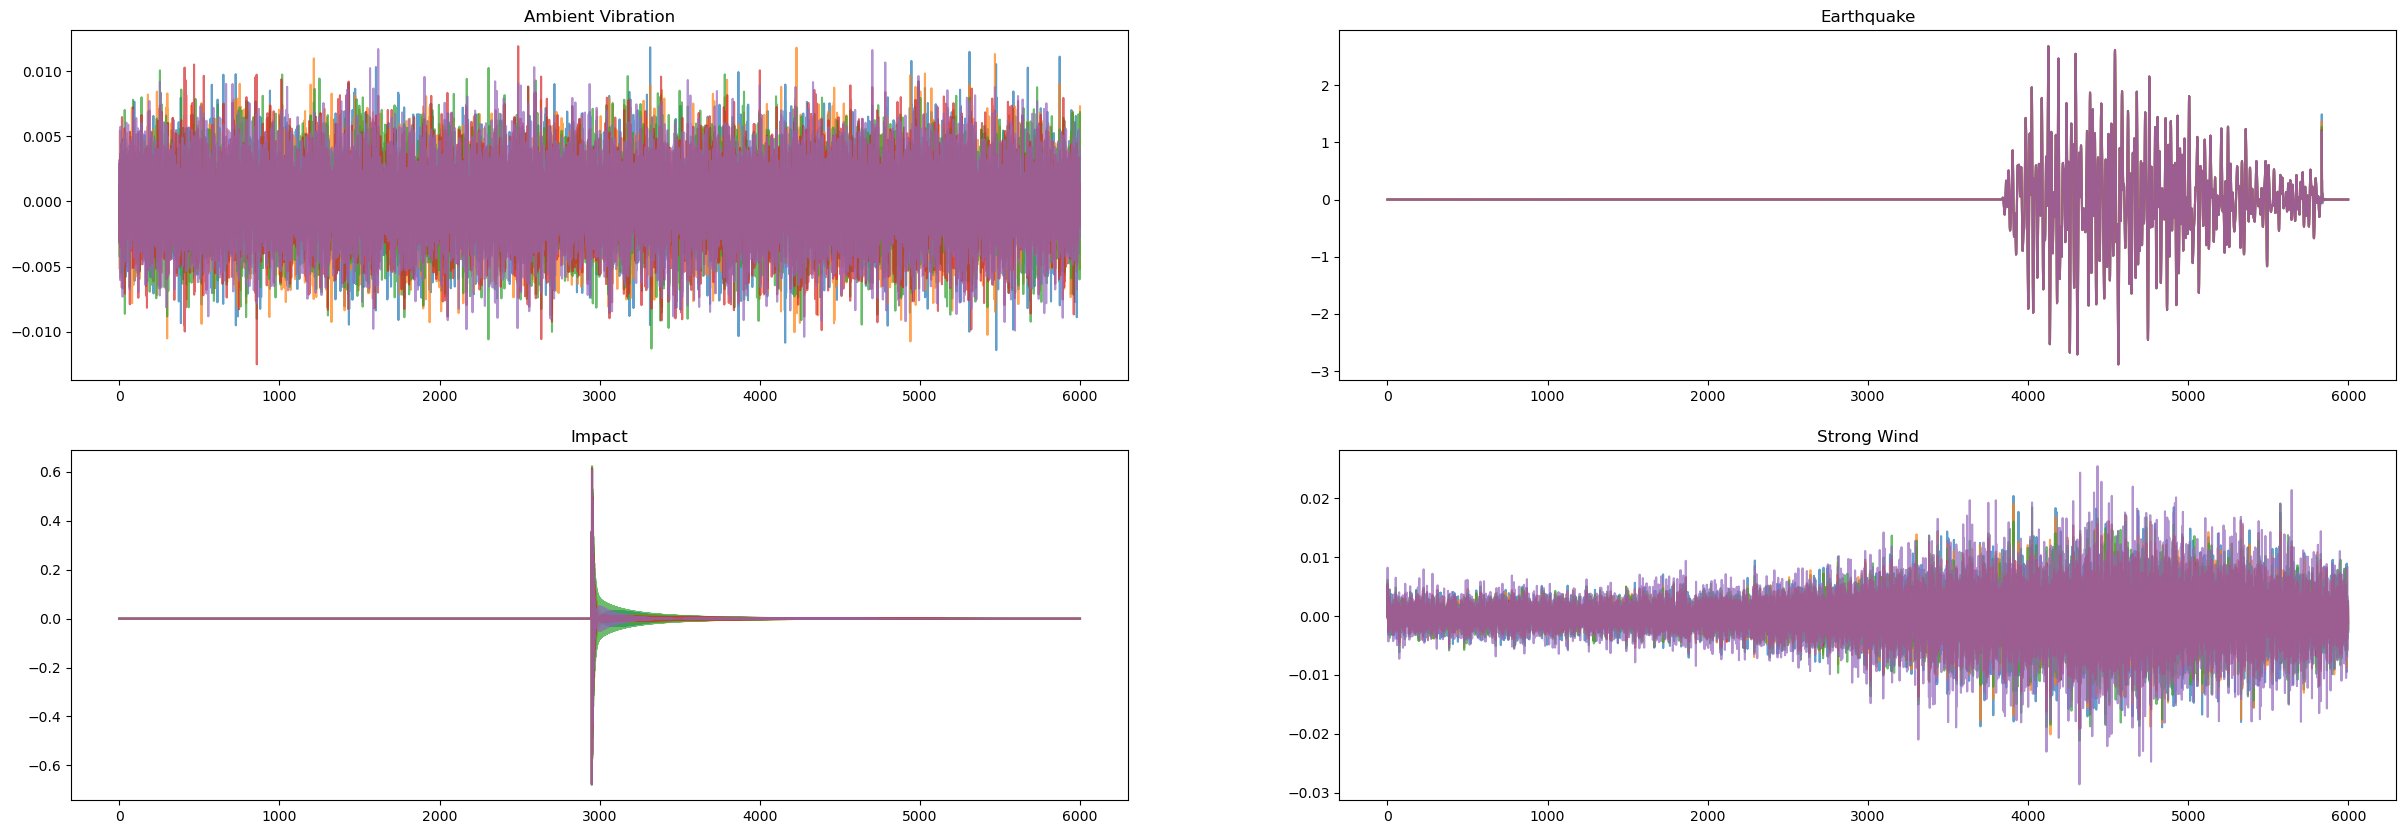

In [11]:
# VISUALIZATION of the RESPONSE

## determine an index to check
index_1 = 0
index_2 = 0

## subplot to show the excitation signals, each subplot contains all the DOFs
plt.figure(figsize=(30, 10))

## AMBIENT VIBRATION
plt.subplot(2, 2, 1)
plt.plot(RESPONSE_AV[index_1, :, :].T, alpha=0.7)
plt.title('Ambient Vibration')

## EARTHQUAKE
plt.subplot(2, 2, 2)
plt.plot(RESPONSE_EQ[index_1, :, :].T, alpha=0.7)
plt.title('Earthquake')

## IMPACT
plt.subplot(2, 2, 3)
plt.plot(RESPONSE_IP[index_1, :, :].T, alpha=0.7)
plt.title('Impact')

## STRONG WIND
plt.subplot(2, 2, 4)
plt.plot(RESPONSE_SW[index_1, :, :].T, alpha=0.7)
plt.title('Strong Wind')

plt.show()


C:\Users\cswof\AppData\Local\Temp\ipykernel_12076\1117614111.py:44: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cswof\AppData\Local\Temp\ipykernel_12076\1117614111.py:44: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cswof\AppData\Local\Temp\ipykernel_12076\1117614111.py:44: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cswof\AppData\Local\Temp\ipykernel_12076\1117614111.py:44: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cswof\AppData\Local\Temp\ipykernel_12076\1117614111.py:44: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\cswof\AppData\Local\Temp\ipykernel_12076\1117614111.py:44: UserWarning: Glyph 25152 (\

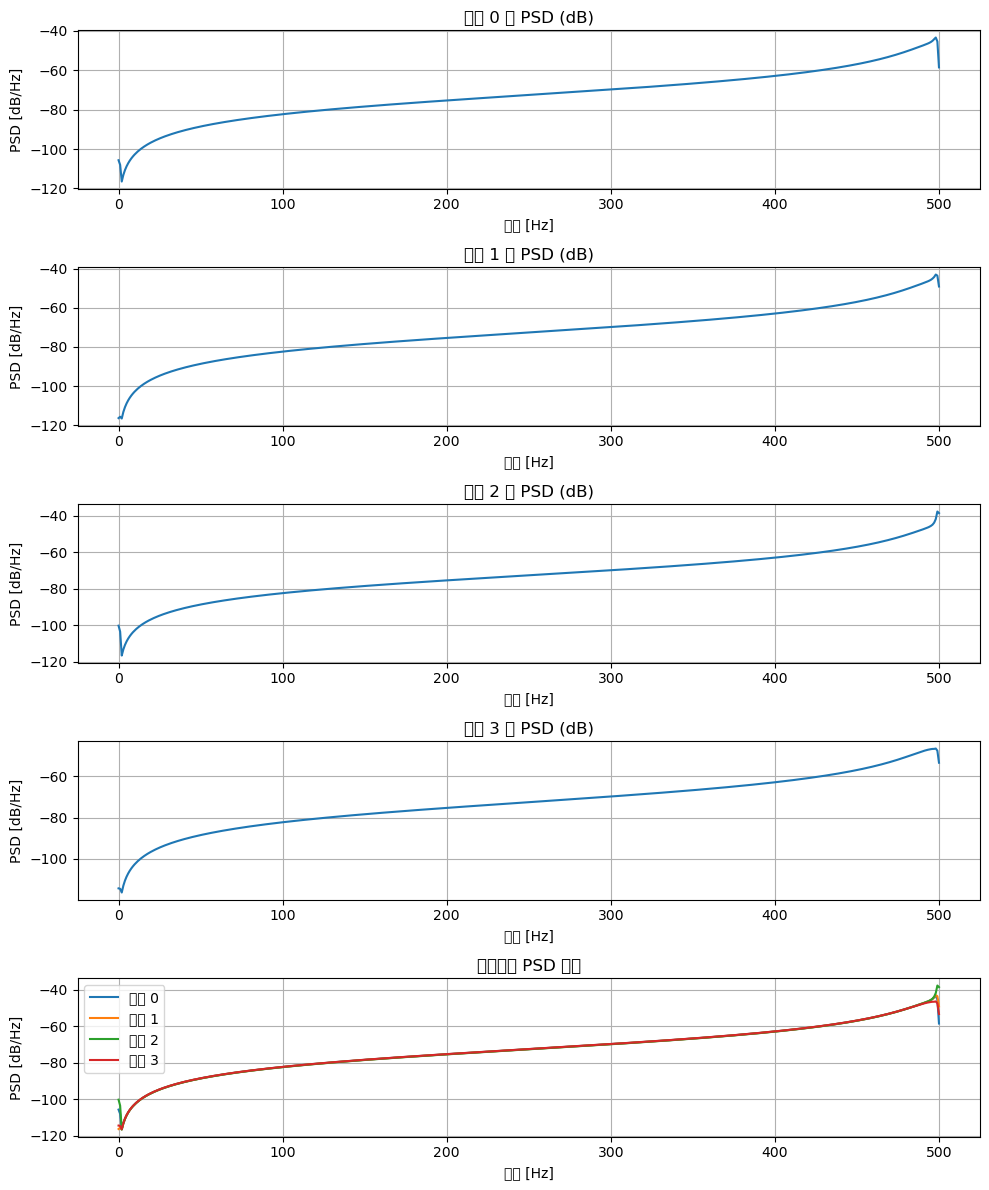

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# 假设 RESPONSE_AV 已经存在，并且数据形状为 (?, ?, ?)
# 这里我们选取 RESPONSE_AV[0, 0:4, :] 作为待处理数据
data = RESPONSE_IP[0, 0:4, :]  # shape (4, N)

# 设置采样频率（根据实际情况修改）
fs = 1000  # 例如采样频率为 1000 Hz

# 准备 5 个子图：4 个单独通道 + 1 个所有通道叠加
fig, axs = plt.subplots(5, 1, figsize=(10, 12))
psd_list = []
freq_list = []

# 对每个通道计算 PSD 并绘图
for i in range(4):
    # 使用 Welch 方法计算 PSD，这里 nperseg 可根据数据长度调整
    f, Pxx = welch(data[i, :], fs=fs, nperseg=1024)
    psd_list.append(Pxx)
    freq_list.append(f)
    
    # 转换为 dB 标度
    Pxx_dB = 10 * np.log10(Pxx)
    
    axs[i].plot(f, Pxx_dB)
    axs[i].set_title(f'通道 {i} 的 PSD (dB)')
    axs[i].set_xlabel('频率 [Hz]')
    axs[i].set_ylabel('PSD [dB/Hz]')
    axs[i].grid(True)

# 第5个子图：所有通道叠加
for i in range(4):
    Pxx_dB = 10 * np.log10(psd_list[i])
    axs[4].plot(freq_list[i], Pxx_dB, label=f'通道 {i}')

axs[4].set_title('所有通道 PSD 叠加')
axs[4].set_xlabel('频率 [Hz]')
axs[4].set_ylabel('PSD [dB/Hz]')
axs[4].legend()
axs[4].grid(True)

plt.tight_layout()
plt.show()
